In [109]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

from math import*

Potential

In [110]:
def V_harmonic(phi,m2):
    return(0.5*m2*phi*phi)

def dV_harmonic(phi,m2):
    return(m2*phi)

def ddV_harmonic(phi,m2):
    return(m2)

In [111]:
from math import pi
csteGrav = 6.6743015e-11
M_pl = 1/np.sqrt(8*pi*csteGrav)
# Units #Internally, the code uses almost everywhere units of Mpc to some power, excepted in the inflation module, where many quantities are in natural units (wrt the true Planck mass).


def V_brane(phi,M4,mu,n):
    return(M4/(1+np.power(mu/phi,n)))

def V_brane_shift(phi,phi0,M4,mu,n):
    return(V_brane(phi0-phi,M4,mu,n))

def dV_brane(phi,M4,mu,n):
    factor = M4*n*np.power(mu,n)
    denom = np.power(phi,n)+np.power(mu,n)
    return(factor*np.power(phi,n-1)/np.power(denom,2))

def dV_brane_shift(phi,phi0,M4,mu,n):
    return(-dV_brane(phi0-phi,M4,mu,n))

def ddV_brane(phi,M4,mu,n):
    factor = M4*n*pow(mu,n)
    factor2 = (n-1)*np.power(mu,n)-(n+1)*np.power(phi,n)
    denom = np.power(mu,n)+np.power(phi,n)
    return(factor*factor2/np.power(denom,3))

def ddV_brane_shift(phi,phi0,M4,mu,n):
    return(ddV_brane(phi0-phi,M4,mu,n))

In [112]:
def epsilon1_true(phi,M4,mu,n):
    factor = 0.5*pow(M_pl,2)
    return(factor*np.power(dV_brane(phi,M4,mu,n)/V_brane(phi,M4,mu,n),2)  )

def epsilon1_true_shift(phi,phi0,M4,mu,n):
    return(epsilon1_true(phi0-phi,M4,mu,n))

Friedmann Equation and Klein-Gordon equation

In [113]:
def equations_scalar_inflation_BI(t, y,M4,mu,n):

    def V(phi):
        return(V_brane(phi,M4,mu,n))

    phi, phi_dot = y

        # Friedmann equation :
    H = 1/M_pl*np.sqrt( (1/3) * (0.5 * phi_dot**2 + V(phi)) )
    
    dV = dV_brane(phi,M4,mu,n)  
    
    # Klein-Gordon equation
    phi_dot_dot = -3 * H * phi_dot - dV 
    
    return [phi_dot, phi_dot_dot]


In [114]:
def equations3_scalar_inflation_BI(t, y,M4,mu,n):

    def V(phi):
        return(V_brane(phi,M4,mu,n))

    phi, phi_dot, a = y

        # Friedmann equation :
    H = 1/M_pl*np.sqrt( (1/3) * (0.5 * phi_dot**2 + V(phi)) )
    
    dV = dV_brane(phi,M4,mu,n)  
    
    # Klein-Gordon equation
    phi_dot_dot = -3 * H * phi_dot - dV 
    
    a_dot = a*H

    return [phi_dot, phi_dot_dot, a_dot]


Friedmann and Klein-Gordon equations with a Shifted potential (decreasing and >0)

In [115]:
def equations_scalar_inflation_shifted_BI(t, y,phi_star,M4,mu,n):

    def V(phi):
        return(V_brane_shift(phi,phi_star,M4,mu,n))

    phi, phi_dot, a = y

        # Friedmann equation :
    H = 1/M_pl*np.sqrt( (1/3) * (0.5 * phi_dot**2 + V(phi)) )
    
    dV = dV_brane_shift(phi,phi_star,M4,mu,n)  
    
    # Klein-Gordon equation
    phi_dot_dot = -3 * H * phi_dot - dV 
    
    a_dot = a*H

    return [phi_dot, phi_dot_dot, a_dot]


Calculation of $\phi_{end}$  (condition : $\epsilon_V = 1$)

In [116]:
def calculate_phi_end(M4,mu,n):
    
    a=-np.sqrt(0.5)*n*pow(mu,n)
    b=pow(mu,4)

    roots = np.roots([1,0,0,0,b,a])
    positive_real_roots = [root for root in roots if np.isreal(root) and root > 0]

    if len(positive_real_roots) > 0:
        return positive_real_roots[0].real 
    else:
        print("No positive real root found.")
        return None

Calculate  $\phi_{start}$ in a bad way, but just for test

In [117]:
## précision nécessaire pour pouvoir atteindre phi tel que  V(phi) proche de M4   (on utilise cette précision dans la fonction calculate phi start)
## Attention, si et seulement si   M_pl = 1
def precision_mu(mu):
    return(pow(10,(-2+4*np.log10(mu/M_pl))))

#Calcule phi tel que V(phi) proche de M4 ... la précision recquise est expliquée après  (en fait elle dépend de M4 et donc de mu  (car M4/mu4 = 16/27))
def calculate_phi_start_BI(M4,mu,n,precision):
    return(mu*pow(M4/precision,1/n))

In [118]:
def calculate_phi_end_BI(M4,mu,n,precision):
    N0=100000
    phi_deb = calculate_phi_start_BI(M4,mu,n,precision)
    list_phi = np.linspace(1e-50,phi_deb,N0)

    V = V_brane(list_phi,M4,mu,n)
    E1 = epsilon1_true(list_phi,M4,mu,n)
 
    i_gauche = 0
    i_droite = N0-1

    i_mid = (i_gauche+i_droite)//2
    
    while (i_droite-i_gauche)>1:
        if E1[i_mid]>1:
            i_gauche=i_mid
        else:
            i_droite=i_mid
        
        i_mid = (i_gauche+i_droite)//2
       
    return(list_phi[i_mid+1])

Initial condition $\frac{d\phi}{dt} \big ( t=t_* \big ) = ... = $ slow roll approx $=$

In [119]:
def phi_dot_star_BI(phi_star,M4,mu,n):
    factor = -sqrt(3)*M_pl
    return(factor*dV_brane(phi_star,M4,mu,n)/sqrt(V_brane(phi_star,M4,mu,n)))

In [120]:
def phi_dot_star_shifted_BI(phi_star,M4,mu,n):
    factor = -sqrt(3)*M_pl
    return(factor*dV_brane(phi_star,M4,mu,n)/sqrt(V_brane(phi_star,M4,mu,n)))

Résolution ED en prenant shifted potential:

- on donne une valeur de $\phi_*$, on intègre l'ED pour trouver $\phi$ et $a$
- on calcule la valeur d' $e$ -folds associée
- on recommence l'opération jusqu'à avoir $60 e$ -folds

Résolution ED

In [121]:
def resolution_scalar_inflation_BI(phi_star,M4,mu,n):
    phi_dot_star = phi_dot_star_BI(phi_star,M4,mu,n)


    y0 = [phi_star,phi_dot_star]
    print("conditions initiales",phi_star,phi_dot_star)
    t_span = (0,1)

    def equations(t,y):
        return(equations_scalar_inflation_BI(t,y,M4,mu,n))

    solution = solve_ivp(equations,t_span,y0,method='RK45')

    t = solution.t
    phi = solution.y[0]
    phi_dot = solution.y[1]

    return(t,phi,phi_dot)


Idem, mais avec $\phi,\dot{\phi}, a$

In [137]:
def resolution3_scalar_inflation_BI(phi_star,M4,mu,n):
    phi_dot_star = phi_dot_star_BI(phi_star,M4,mu,n)
    a_star = 1

    y0 = [phi_star,phi_dot_star,a_star]

    print("conditions initiales",phi_star,phi_dot_star,a_star)
    
    t_span = (0,10)  #combien?

    def equations3(t,y):
        return(equations3_scalar_inflation_BI(t,y,M4,mu,n))

    solution = solve_ivp(equations3,t_span,y0,method='RK45')

    t = solution.t
    phi = solution.y[0]
    phi_dot = solution.y[1]
    a = solution.y[0]

    a_dot = np.gradient(a,t)

    return(t,phi,phi_dot,a,a_dot)


Résolution ED et plot

In [123]:
def couleur(i,N):
    myColor = plt.get_cmap("Dark2")
    return(myColor((i+1)/N))

In [124]:
def resolution_BI_plot(phi_star,M4,mu,n,c,c2):
    t,phi,phi_dot = resolution_scalar_inflation_BI(phi_star,M4,mu,n)
    t2,phi2,phi_dot2,a2,a_dot2 = resolution3_scalar_inflation_BI(phi_star,M4,mu,n)

    fig = plt.figure(figsize=(13,10))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    ax3 = plt.subplot(2,2,3)
    ax4 = plt.subplot(2,2,4)

    V = V_brane(phi,M4,mu,n)
    V2 = V_brane(phi2,M4,mu,n)
    
    dV = dV_brane(phi,M4,mu,n)


    ax1.plot(t,phi,color=c,label="2")
    ax1.set_ylabel(r'$\phi(t)$')
    ax1.set_xlabel(r'$t$')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    ax2.plot(t,phi_dot,color=c,label="2")
    ax2.set_ylabel(r'$\frac{d\phi}{dt}$')
    ax2.set_xlabel(r'$t$')

    ax3.plot(phi,V,color=c,label="2")
    ax3.set_ylabel(r'$V(\phi)$')
    ax3.set_xlabel(r'$\phi$')

    print("temps",t)
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()

    
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10,7))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    ax3 = plt.subplot(2,2,3)
    ax4 = plt.subplot(2,2,4)

    ax1.plot(t2,phi2,color=c2,label="3")
    ax1.set_ylabel(r'$\phi(t)$')
    ax1.set_xlabel(r'$t$')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax2.plot(t2,phi_dot2,color=c2,label="3")
    ax2.set_ylabel(r'$\frac{d\phi}{dt}$')
    ax2.set_xlabel(r'$t$')

    ax3.plot(phi,V,color=c2,label="3")
    ax3.set_ylabel(r'$V(\phi)$')
    ax3.set_xlabel(r'$\phi$')

    ax4.plot(t2,a2,color=c2,label="3")
    ax4.set_ylabel(r'$a(t)$')
    ax4.set_xlabel(r'$t$')

    print("temps 2",t2)
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()

    plt.tight_layout()
    plt.show()
    

In [125]:
def essai_resolution_BI_plot():

    n=4
    liste_mu = M_pl*np.logspace(0,0,1)
    liste_M4=4*np.pi*np.pi*np.power(liste_mu,4)*16/27
    
    liste_eta = [ precision_mu(mu) for mu in liste_mu ]

    
    NN=len(liste_mu)
    for i in range(NN):
        mu = liste_mu[i]
        M4=liste_M4[i]
        eta=liste_eta[i]
        phi_star  = calculate_phi_start_BI(M4,mu,n,eta)

        print(phi_star)
        phi_star = M_pl*pow(10,1)
        print(phi_star)
        print("")
        resolution_BI_plot(phi_star,M4,mu,n,"b","r")


# essai_resolution_BI_plot()

Cacul de $\Delta N = \int_{a_{end}}^{a_*} dlna = \int_{\phi_{end}}^{\phi_*} \frac{H(\phi)}{\dot{\phi}} d\phi$

In [126]:
# from scipy import integrate

def calculate_N(phi1,phi2,t,phi,phi_dot,a,a_dot):
    integrande = [ a_dot[i]/(a[i]*phi_dot[i])  for i in range(len(t))]
    index_phi1 = np.searchsorted(phi,phi1,side="right")
    index_phi2 = np.searchsorted(phi,phi2,side="right")

    phi_sub = np.array(phi[index_phi1:index_phi2][::-1])
    integrande_sub = np.array([integrande[i] for i in range(index_phi1, index_phi2)][::-1])

    N = np.trapz(phi_sub,integrande_sub)
    return(N)

In [153]:
def resolution_and_calculate_DN_BI(phi_star,M4,mu,n,precision):
    t_,phi_,phi_dot_,a_,a_dot_ = resolution3_scalar_inflation_BI(phi_star,M4,mu,n)
    t = t_[1:-1]
    phi = phi_[1:-1]
    phi_dot = phi_dot_[1:-1]
    a = a_[1:-1]
    a_dot = a_dot_[1:-1]

    V = V_brane(phi,M4,mu,n)
    dV = dV_brane(phi,M4,mu,n)

    phi_end = calculate_phi_end(M4,mu,n)
    phi_endd = calculate_phi_end_BI(M4,mu,n,precision)

    N = calculate_N(phi_star,phi_end,t,phi,phi_dot,a,a_dot)
    N2 = calculate_N(phi_star,phi_endd,t,phi,phi_dot,a,a_dot)
    print("phi_start",phi_star)
    print("phi_end roots",phi_end)
    print("phi_end",phi_endd)
    print("e-folds",N)
    print("e-folds bis",N2)

    fig = plt.figure(figsize=(17,10))
    ax1 = plt.subplot(2,3,1)
    ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    ax4 = plt.subplot(2,3,4)
    ax5 = plt.subplot(2,3,5)
    ax6 = plt.subplot(2,3,6)

    ax1.plot(t,phi,color="b")
    ax1.set_ylabel(r'$\phi(t)$')
    ax1.set_xlabel(r'$t$')

    ax2.loglog(t,phi,color="b")
    ax2.set_ylabel(r'$\phi(t)$')
    ax2.set_xlabel(r'$t$')

    ax3.plot(t,phi_dot,color="b")
    ax3.set_ylabel(r'$\frac{d\phi}{dt}$')
    ax3.set_xlabel(r'$t$')

    ax4.plot(phi,V/M4,color="b")
    ax4.set_ylabel(r'$V(\phi)/M^4$')
    ax4.set_xlabel(r'$\phi$')

    ax5.plot(phi,t,color="b")
    ax5.set_ylabel(r'$V$')
    ax5.set_xlabel(r'$t$')

    ax6.plot(t,a,color="b")
    ax6.set_ylabel(r'$a(t)$')
    ax6.set_xlabel(r'$t$')
    
    plt.tight_layout()
    plt.show()
    

conditions initiales 10000 -7848356388.740642 1
phi_start 10000
phi_end roots 2.82842712474619
phi_end 41460.79743437717
e-folds 0.0
e-folds bis 0.0


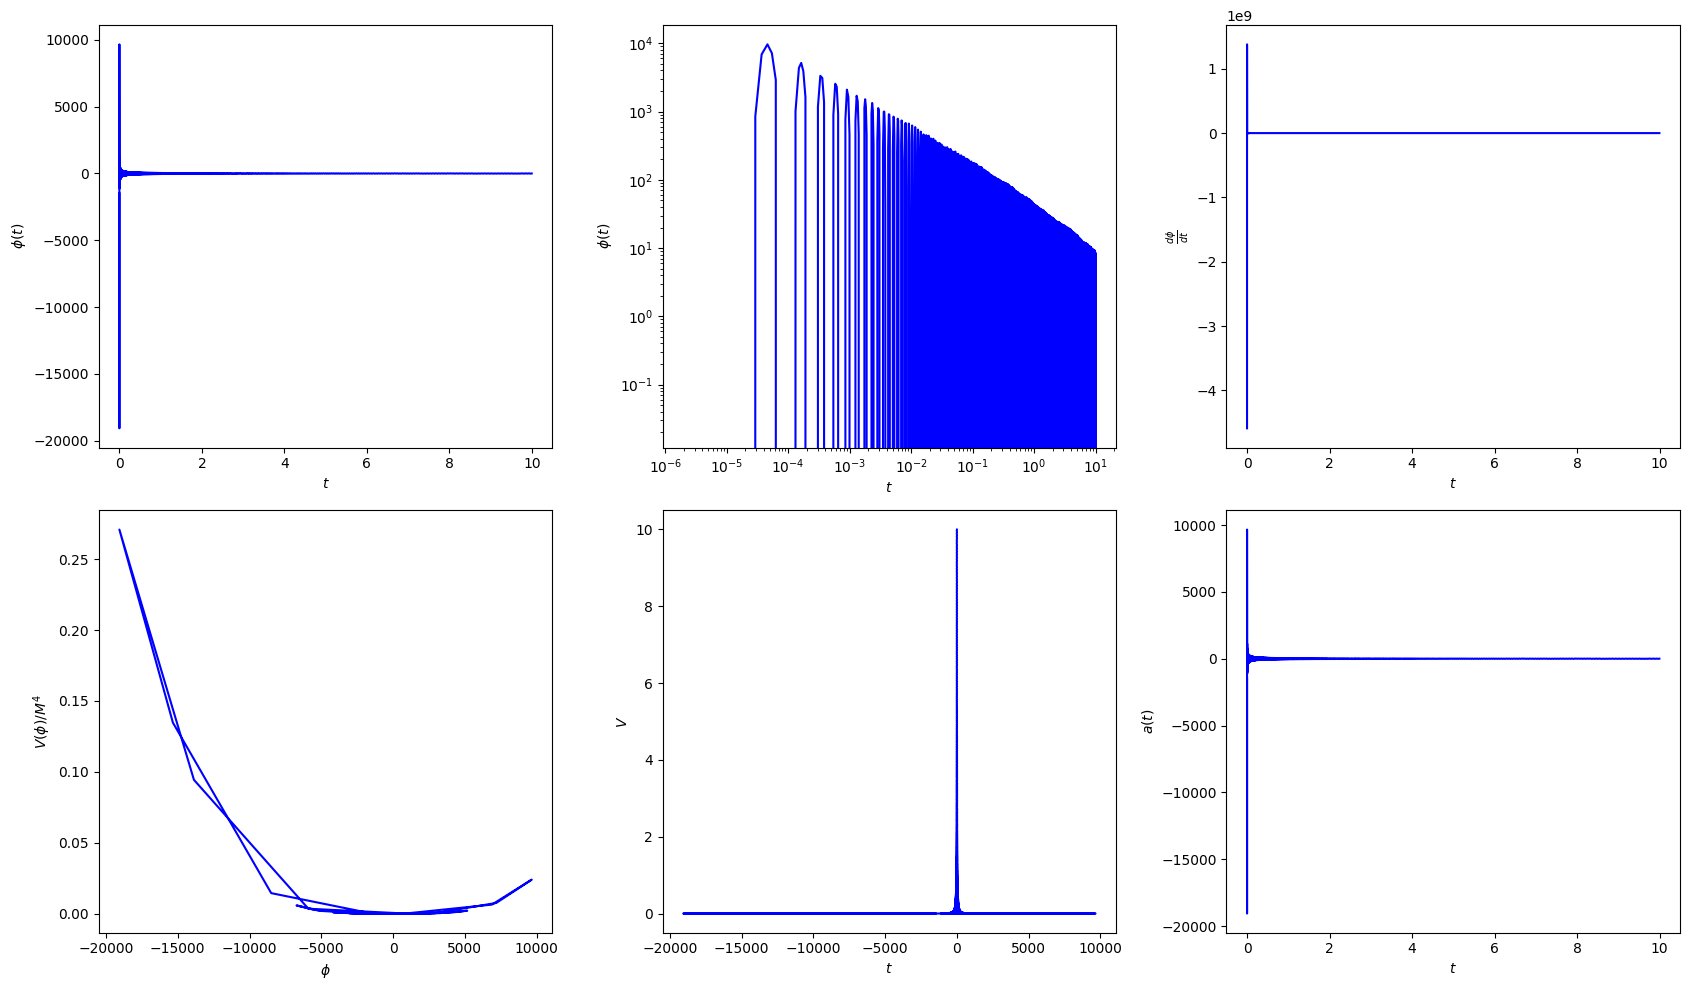

In [155]:
def essai_resolution_and_calculate_DN():

    n=4
    liste_mu = M_pl*np.logspace(0,0,1)
    liste_M4=4*np.pi*np.pi*np.power(liste_mu,4)*16/27
    
    liste_eta = [ precision_mu(mu) for mu in liste_mu ]

    
    NN=len(liste_mu)
    for i in range(NN):
        mu = liste_mu[i]
        M4=liste_M4[i]
        eta=liste_eta[i]
        
        
        phi_star = 10000
        resolution_and_calculate_DN_BI(phi_star,M4,mu,n,eta)
        print("")


essai_resolution_and_calculate_DN()